In [128]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import pandas as pd
import chardet
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import torch
from nltk.corpus import stopwords
import seaborn as sb
import matplotlib.patches as mpatches
import random
from matplotlib.lines import Line2D


In [3]:
df = pd.read_csv('Food.csv')

In [4]:
df.head(1)

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


In [5]:
df.shape

(568454, 8)

In [15]:
stop = stopwords.words('english')


In [17]:
df['text_without_stopwords'] = df['review/text'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stop)]).lower())

In [18]:
df.head(1)

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,text_without_stopwords
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,i bought several vitality canned dog food prod...


In [22]:
analyzer = SentimentIntensityAnalyzer()
def get_sentiment(text):
#     sentiment = model(text)[0]['label']
#     print(text)
    res = analyzer.polarity_scores(str(text))
    return [res['pos'], res['neu'], res['neg']]

In [23]:
store = df['text_without_stopwords'].apply(get_sentiment)

In [49]:
store.values

array([list([0.444, 0.556, 0.0]), list([0.106, 0.801, 0.092]),
       list([0.228, 0.634, 0.139]), ..., list([0.0, 1.0, 0.0]),
       list([0.0, 1.0, 0.0]), list([0.0, 1.0, 0.0])], dtype=object)

In [52]:
pos = [x[0] for x in store]
neu = [x[1] for x in store]
neg = [x[2] for x in store]


In [54]:
df['pos'] = pos
df['neu'] = neu
df['neg'] = neg

In [56]:
df.head(2)

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,text_without_stopwords,pos,neu,neg
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,i bought several vitality canned dog food prod...,0.444,0.556,0.000
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanuts.....,0.106,0.801,0.092


In [75]:
helpfulness = []
for index, row in df.iterrows():
    helpfulness.append(int(row['review/helpfulness'][0]))

In [76]:
df['helpfulness'] = helpfulness

In [77]:
df.head(1)

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,text_without_stopwords,pos,neu,neg,helpfulness
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,i bought several vitality canned dog food prod...,0.444,0.556,0.0,1


In [79]:
df['review/time'] = pd.to_datetime(df['review/time'],unit='s')

In [82]:
df['review/score'] = df['review/score'].astype(int)

In [83]:
df.head(1)

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,text_without_stopwords,pos,neu,neg,helpfulness
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,i bought several vitality canned dog food prod...,0.444,0.556,0.0,1


C:\Users\Jignasu\AppData\Local\Temp\ipykernel_15704\3694307617.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataplot = sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)


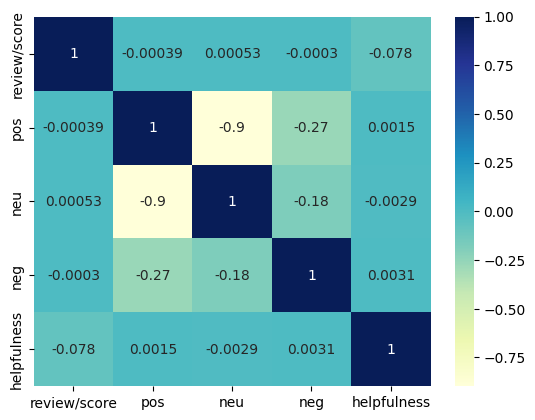

In [84]:
# plotting correlation heatmap
dataplot = sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

# Bipartite network

In [85]:
BiPartite = nx.Graph()


In [87]:
for index, row in df.iterrows():
    BiPartite.add_node(row['product/productId'], bipartite=0)  # Add product node with bipartite attribute set to 0
    BiPartite.add_node(row['review/profileName'], bipartite=1)  # Add user node with bipartite attribute set to 1
    BiPartite.add_edge(row['product/productId'], row['review/profileName'])  # Add edge between product and user nodes

In [125]:
# Extract nodes from a particular partition
product_nodes = [n for n, d in BiPartite.nodes(data=True) if d['bipartite'] == 0]
user_nodes = [n for n, d in BiPartite.nodes(data=True) if d['bipartite'] == 1]

selected_userIDs = random.sample(user_nodes, 30)  # Choose 2 userIDs randomly
subsampled_graph = nx.Graph()
for user in selected_userIDs:
    subsampled_graph.add_node(user, bipartite=0)
    for product in BiPartite.neighbors(user):
        subsampled_graph.add_node(product, bipartite=1)
        subsampled_graph.add_edge(user, product)
        
# Define node colors based on their type
colors = []
for node, data in subsampled_graph.nodes(data=True):
    if data['bipartite'] == 0:
        colors.append('red')  # userIDs
    else:
        colors.append('blue')  # productIDs

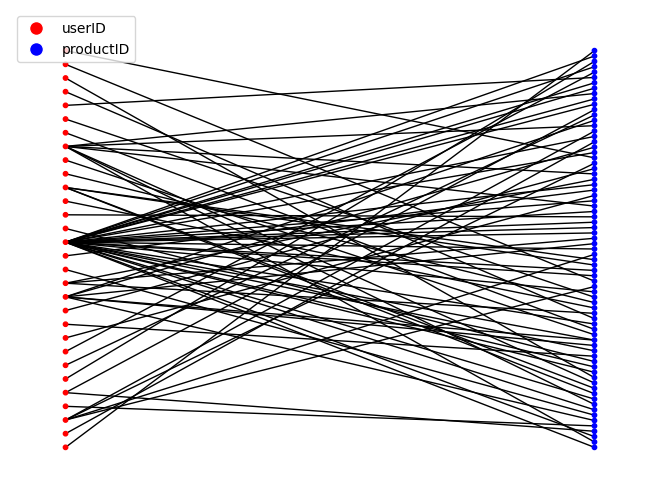

<Figure size 10000x10000 with 0 Axes>

In [132]:
pos = nx.bipartite_layout(subsampled_graph, nodes=[n for n, d in subsampled_graph.nodes(data=True) if d['bipartite'] == 0])
nx.draw(subsampled_graph, pos, with_labels=False, node_size=10, node_color=colors)


legend_elements = [Line2D([0], [0], marker='o', color='w', label='userID', markerfacecolor='red', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='productID', markerfacecolor='blue', markersize=10)]

plt.legend(handles=legend_elements, loc='upper left')
plt.figure(figsize=(100,100))
plt.show()

In [133]:
selected_userIDs = random.sample(user_nodes, 100)  # Choose 2 userIDs randomly
subsampled_graph = nx.Graph()
for user in selected_userIDs:
    subsampled_graph.add_node(user, bipartite=0)
    for product in BiPartite.neighbors(user):
        subsampled_graph.add_node(product, bipartite=1)
        subsampled_graph.add_edge(user, product)
        
# Define node colors based on their type
colors = []
for node, data in subsampled_graph.nodes(data=True):
    if data['bipartite'] == 0:
        colors.append('red')  # userIDs
    else:
        colors.append('blue')  # productIDs

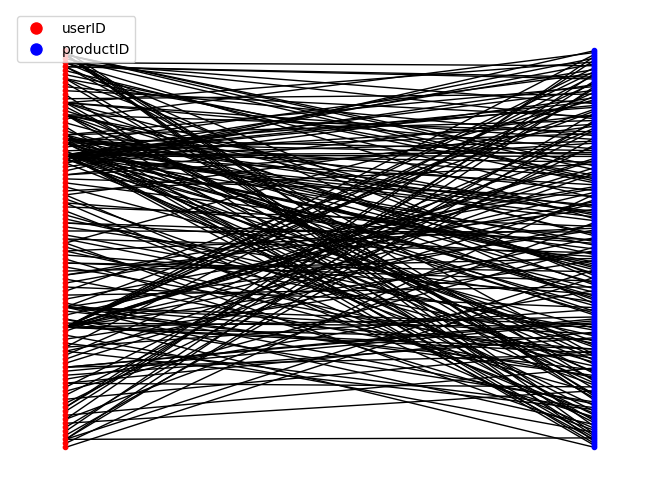

<Figure size 10000x10000 with 0 Axes>

In [134]:
pos = nx.bipartite_layout(subsampled_graph, nodes=[n for n, d in subsampled_graph.nodes(data=True) if d['bipartite'] == 0])
nx.draw(subsampled_graph, pos, with_labels=False, node_size=10, node_color=colors)


legend_elements = [Line2D([0], [0], marker='o', color='w', label='userID', markerfacecolor='red', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='productID', markerfacecolor='blue', markersize=10)]

plt.legend(handles=legend_elements, loc='upper left')
plt.figure(figsize=(100,100))
plt.show()

# Weighted edges

In [138]:
BiPartite = nx.Graph()

In [140]:
for index, row in df.iterrows():
    BiPartite.add_node(row['product/productId'], bipartite=0)  # Add source node with bipartite attribute set to 0
    BiPartite.add_node(row['review/profileName'], bipartite=1)  # Add target node with bipartite attribute set to 1
    BiPartite.add_edge(row['product/productId'], row['review/profileName'], weight=row['helpfulness'])  # Add edge with weight

In [162]:
# Select a random sample of source nodes
source_nodes = [n for n, d in BiPartite.nodes(data=True) if d['bipartite'] == 1]
sample_size = 10  # Adjust the sample size as needed
sampled_source_nodes = random.sample(source_nodes, sample_size)

# Create a subgraph containing the sampled source nodes and their associated target nodes
sampled_edges = [(u, v) for u, v in BiPartite.edges if u in sampled_source_nodes]
sampled_nodes = set([u for u, v in sampled_edges] + [v for u, v in sampled_edges])
Sampled_BiPartite = BiPartite.subgraph(sampled_nodes)

In [167]:
# Calculate edge widths based on weights
edge_weights = [Sampled_BiPartite[u][v]['weight'] for u, v in Sampled_BiPartite.edges()]
max_weight = max(edge_weights)
min_width = 0.1  # Minimum edge width
max_width = 5  # Maximum edge width
edge_widths = [((w / max_weight) * (max_width - min_width)) + min_width for w in edge_weights]

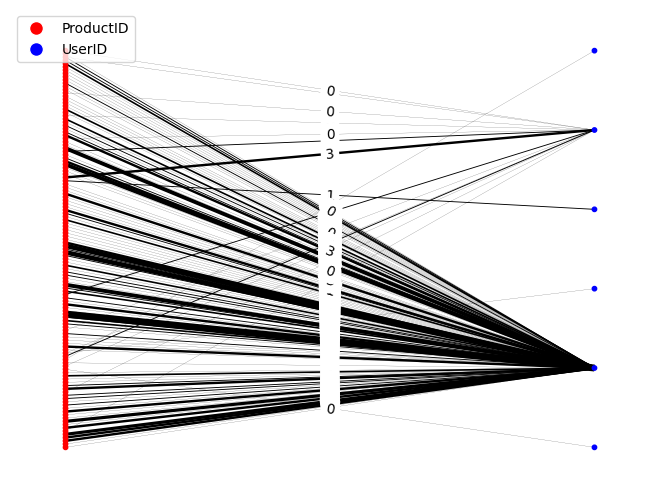

In [168]:
# Plot the sampled bipartite graph with varying edge widths
colors = ['red' if data['bipartite'] == 0 else 'blue' for _, data in Sampled_BiPartite.nodes(data=True)]
pos = nx.bipartite_layout(Sampled_BiPartite, [n for n, d in Sampled_BiPartite.nodes(data=True) if d['bipartite'] == 0])
nx.draw(Sampled_BiPartite, pos, node_color=colors, with_labels=False, node_size=10, font_size=5, font_weight='bold', width=edge_widths)

# Draw edge labels (weights)
edge_labels = nx.get_edge_attributes(Sampled_BiPartite, 'weight')
nx.draw_networkx_edge_labels(Sampled_BiPartite, pos, edge_labels=edge_labels)

# Create a custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='ProductID', markerfacecolor='red', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='UserID', markerfacecolor='blue', markersize=10)]

plt.legend(handles=legend_elements, loc='upper left')
plt.show()